In [81]:
import imageio as io
import os
import PIL
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import scanpy as sc
from tqdm.notebook import tqdm
PIL.Image.MAX_IMAGE_PIXELS = 4902390226

# Put the path to the cell boundary staining below

In [14]:
xenium_path = 'D:/amonell/RaRi/output-XETG00095__0005184__DMSO__20230715__015401'

In [15]:
cell_boundary_channel = 1

In [16]:
if_channel_cell_boundary = io.imread(os.path.join(xenium_path, f'IF_warped_channel{cell_boundary_channel}.png'))

C:\Users\amonell\AppData\Local\Temp\3\ipykernel_49140\1431135787.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if_channel_cell_boundary = io.imread(os.path.join(xenium_path, f'IF_warped_channel{cell_boundary_channel}.png'))
C:\Users\amonell\anaconda3_2\envs\cellpose_only\lib\site-packages\imageio\plugins\pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


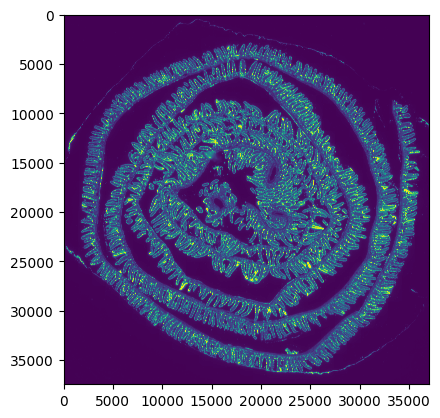

In [12]:
plt.imshow(if_channel_cell_boundary)

In [19]:
try:
    os.mkdir(os.path.join(xenium_path, 'villi_images'))
except:
    print('Villi images directory already made')

# Chunk the image, and write it out

In [17]:
# Read the image
downsize_factor = 5
pad_height = (downsize_factor - if_channel_cell_boundary.shape[0] % downsize_factor) % downsize_factor
pad_width = (downsize_factor - if_channel_cell_boundary.shape[1] % downsize_factor) % downsize_factor

# Pad the array with zeros
padded_array = np.pad(if_channel_cell_boundary, ((0, pad_height), (0, pad_width)), mode='constant')

In [75]:
new_width = int(padded_array.shape[1] /downsize_factor) 
new_height = int(padded_array.shape[0] / downsize_factor)

image = cv2.resize(padded_array.astype(np.float32), (new_width, new_height))


## Training Villi segmentation model - Only do if existing villi segmentation model needs changing

#### Make small chunks for training in cellpose GUI

In [58]:


#cv2.imwrite(os.path.join(xenium_path, 'villi_images', f'image.png'), image)
# Define the chunk size
chunk_size = (1000, 1000)

for i in tqdm(range(0, image.shape[1], int(chunk_size[1]/2))):
    for j in range(0, image.shape[0], int(chunk_size[0]/2)):
        # Define the coordinates for cropping
        left = i
        upper = j
        right = i + chunk_size[1]
        lower = j + chunk_size[0]

        # Crop the image chunk
        chunk = image[upper:lower, left:right]

        cv2.imwrite(os.path.join(xenium_path, 'villi_images', f'chunk_{i}_{j}.png'), ((chunk/np.max(chunk))*255).astype(int))

  0%|          | 0/15 [00:00<?, ?it/s]

#### Make Large Chunks for faster training once base model is optimized for a few (1000, 1000) chunks

In [9]:
files_to_remove = glob.glob(os.path.join(xenium_path, 'villi_images', '*.png'))

for file_path in files_to_remove:
    try:
        os.remove(file_path)
    except Exception as e:
        print(f"Error while removing {file_path}: {e}")

In [10]:
chunk_size = (5000, 5000)

for i in tqdm(range(0, image.shape[1], int(chunk_size[1]/2))):
    for j in range(0, image.shape[0], int(chunk_size[0]/2)):
        # Define the coordinates for cropping
        left = i
        upper = j
        right = i + chunk_size[1]
        lower = j + chunk_size[0]

        # Crop the image chunk
        chunk = image[upper:lower, left:right]

        cv2.imwrite(os.path.join(xenium_path, 'villi_images', f'chunk_{i}_{j}.png'), ((chunk/np.max(chunk))*255).astype(int))

  0%|          | 0/3 [00:00<?, ?it/s]

## Segmenting Villi 

I'm putting the model in the models folder with all the notebooks

In [77]:
cellpose_model_path = r'D:/amonell/RaRi/output-XETG00095__0005184__DMSO__20230715__015401/villi_images/models/villi_segmentation'

In [78]:
from cellpose import models
from cellpose import io as cio
model = models.CellposeModel(gpu=True, pretrained_model= cellpose_model_path)
channels = [0,0]
masks_, flows_, styles_= model.eval([((image/np.max(image))*255).astype(int)], channels=channels, diameter=181.35,flow_threshold=0, cellprob_threshold=0)


In [79]:
np.save(os.path.join(xenium_path, 'villi_segmentation_mask.npy'), masks_[0])

In [80]:
np.save(os.path.join(xenium_path, 'villi_segmentation_downsize_factor.npy'), np.array([downsize_factor]))

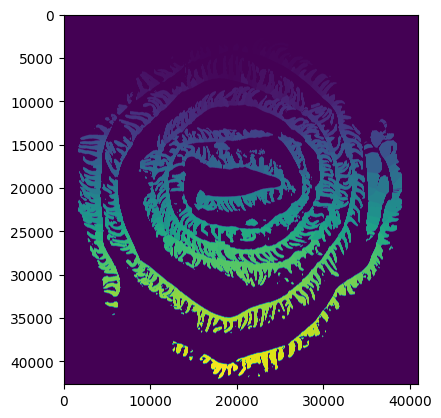

In [26]:
plt.imshow(masks_[0])